In [1]:
import numpy as np
import pandas as pd
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt
%run ./../custom_functions/get_scoring_measures.ipynb

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
%matplotlib inline

In [35]:
# Extracting the data of both frequencies (high and daily)

rf_OF_results = pd.read_csv('./../../../Databases/results_data/rf_results.csv', index_col = 'Timestamp')
rf_DF_results = pd.read_csv('./../../../Databases/results_data/rf_dailyresults.csv', index_col = 'Timestamp')
rf_10d_results = pd.read_csv('./../../../Databases/results_data/rf_10day_results.csv', index_col = 'Timestamp')
rf_10d_runtime = pd.read_csv('./../../../Databases/results_data/rf_10day_runtime_scenarios.csv')
rf_OF_runtime = pd.read_csv('./../../../Databases/results_data/rf_runtime_scenarios.csv')
rf_DF_runtime = pd.read_csv('./../../../Databases/results_data/rf_runtime_dailyscenarios.csv')

### Original frequency analysis

Due to the properties of the RandomForest algorithm and the design of the custom function to get new predictions, the computing cost would have been too high to predict all time stamps on X_test. Therefore, predictions for the whole X_test proportion have been calculated without refitting the model each iteration and predictions for the first 10 days have been calculated as well with the normal refitting process.

In [5]:
rf_OF_results.head()

,Observed_values,TotEntr_PKF_allcols,TotEntr_PKF_lags,TotEntr_PUF_allcols,TotEntr_PUF_lags
Timestamp,,,,,
2018-09-24 00:00:00,20,15.470000,15.475000,15.4700,15.475000
2018-09-24 00:30:00,0,0.772719,0.703395,55.3450,0.703395
2018-09-24 01:00:00,0,0.000000,0.000000,38.8900,0.000000
2018-09-24 01:30:00,0,0.000000,0.000000,32.0025,0.000000
2018-09-24 02:00:00,0,0.000000,0.000000,15.5425,0.000000


In [12]:
# All_columns regressors:   340      Just_lags regressors: 336
rf_OF_scorings = get_scoring_measures(rf_OF_results, 336, 340)
rf_OF_scorings

,RMSE,R2_adjusted
TotEntr_PKF_allcols,21.702826,1.013633
TotEntr_PKF_lags,21.727448,1.012980
TotEntr_PUF_allcols,162.344790,-0.887123
TotEntr_PUF_lags,75.540566,0.628837


Predicting unknown future: judging from this results, there seems to be a better adjustment to the observations using just lags than including all columns.

Let's compare the results of the first 10 days obtained without fitting the model in each iteration vs. refitting it:

#### No refitting:

In [24]:
get_scoring_measures(rf_OF_results[:480], 336, 340)

,RMSE,R2_adjusted
TotEntr_PKF_allcols,23.079490,3.358474
TotEntr_PKF_lags,22.884807,3.265960
TotEntr_PUF_allcols,209.261200,-3.753036
TotEntr_PUF_lags,48.706099,2.970558


#### Refitting:

In [22]:
rf_10d_df = pd.concat([rf_OF_results[['Observed_values','TotEntr_PKF_allcols', 'TotEntr_PKF_lags']][:480], rf_10d_results.drop('Observed_values', axis=1) ], axis=1, sort=True)
rf_10d_scorings = get_scoring_measures(rf_10d_df, 336, 340)
rf_10d_df.head()

,Observed_values,TotEntr_PKF_allcols,TotEntr_PKF_lags,TotEntr_PUF_allcols_10d,TotEntr_PUF_lags_10d
Timestamp,,,,,
2018-09-24 00:00:00,20,15.470000,15.475000,15.470000,15.475000
2018-09-24 00:30:00,0,0.772719,0.703395,5.364594,0.703488
2018-09-24 01:00:00,0,0.000000,0.000000,0.396983,0.000000
2018-09-24 01:30:00,0,0.000000,0.000000,0.000000,0.000000
2018-09-24 02:00:00,0,0.000000,0.000000,0.000000,0.000000


In [23]:
rf_10d_scorings

,RMSE,R2_adjusted
TotEntr_PKF_allcols,23.079490,3.358474
TotEntr_PKF_lags,22.884807,3.265960
TotEntr_PUF_allcols_10d,47.711566,3.071806
TotEntr_PUF_lags_10d,48.494400,2.973846


When refitting the model with each new prediction, the results improve dramatically on the all columns scenario (both in terms of RMSE and R2_adjusted). The more important point, though, is that there doesn't seem to be much difference on scorings on the just lags scenario. Actually, the scorings when no refitting are pretty close to the ones obtained refitting in each iteration using all columns.

It will be discussed on a further section, but could mean big savings in computing costs.

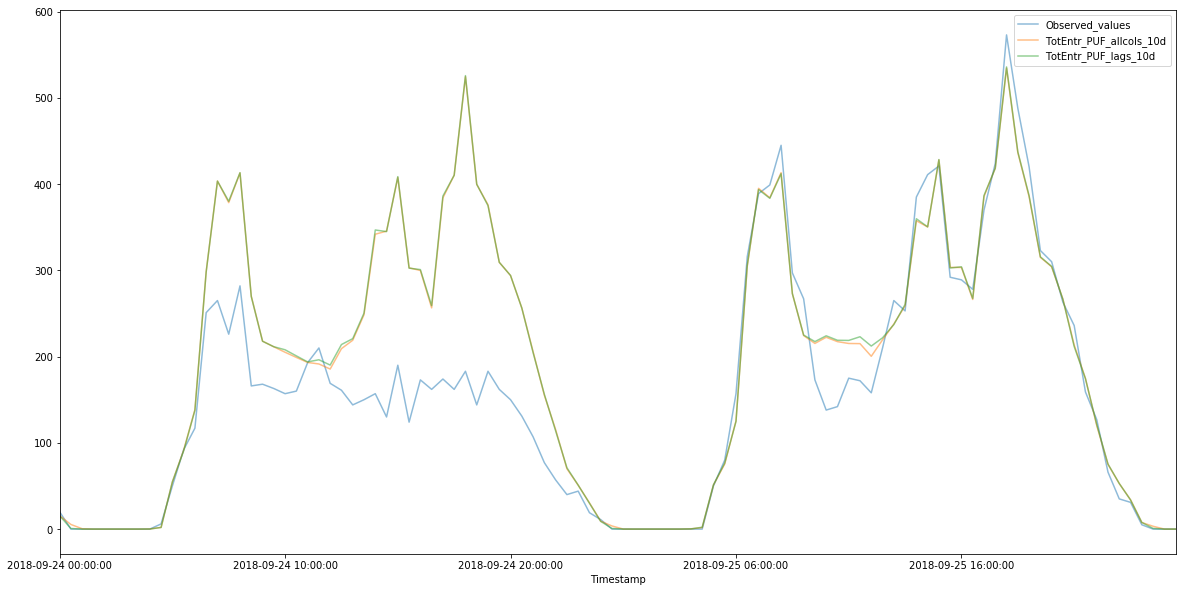

In [28]:
# Let's plot the first 100 predictions vs. the observed values to get an idea
# of the differences.

ax = rf_10d_df.drop(['TotEntr_PKF_allcols', 'TotEntr_PKF_lags'], axis=1)[:100].plot(figsize=(20,10), alpha=0.5, legend=True)
plt.show()

The first day of predictions show a big deviation from the observation than mitigates the next day. Both all columns scenario and just lags draw almost the same pattern.

The model with that yields the best results seems to be the one using all columns (refitting each iteration). We just have 10 days of predictions, but will proceed to the analysis of its results anyway.

### Residual analysis

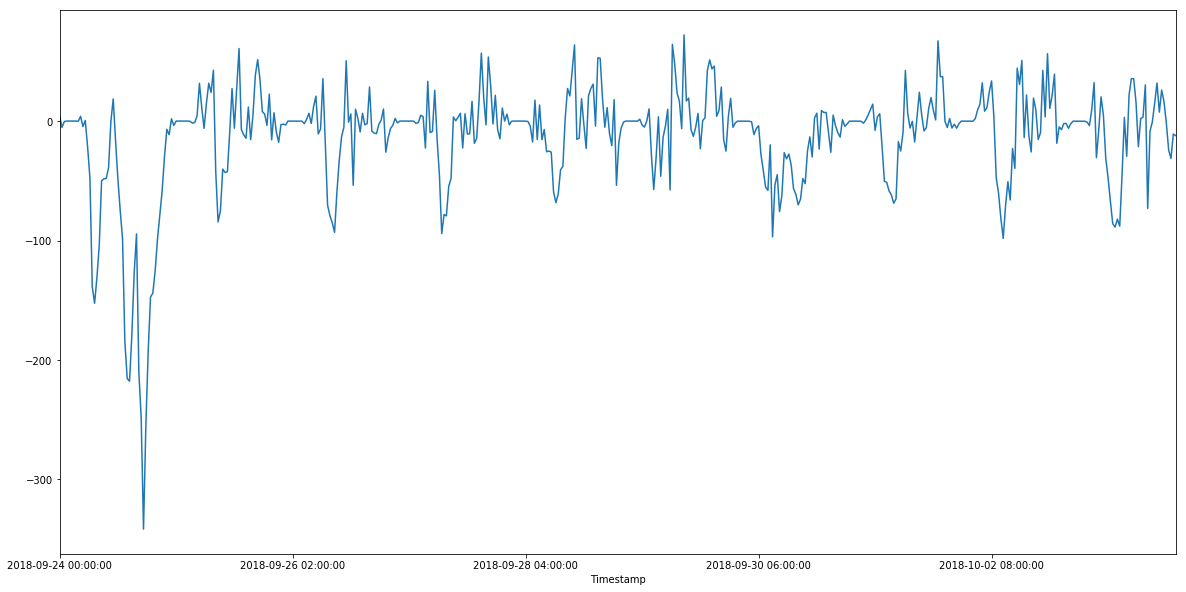

In [30]:
# Let's plot the residuals to see if there's a visible pattern:

rf_10d_residuals = rf_10d_results['Observed_values'] - rf_10d_results['TotEntr_PUF_allcols_10d']

rf_10d_residuals.plot(figsize=(20,10))
plt.show()

Setting aside the first day of observations, there seems to be a cycle of valleys and peaks that repeat each day (with different intensity).

In [31]:
rf_10d_residuals.describe()

count    480.000000
mean     -13.749476
std       45.735142
min     -341.525000
25%      -22.674675
50%       -1.644651
75%        5.572409
max       72.124959
dtype: float64

As in the case of the other regressors studies (linear regression and ARIMA), there's a deviation towards negative values.

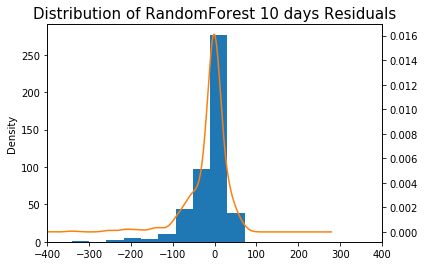

In [32]:
# Histogram and density of residuals

ax = rf_10d_residuals.hist()
rf_10d_residuals.plot(kind='kde', ax=ax, secondary_y=True, xlim=(-400,400))
plt.title('Distribution of RandomForest 10 days Residuals', fontsize=15)
plt.show()

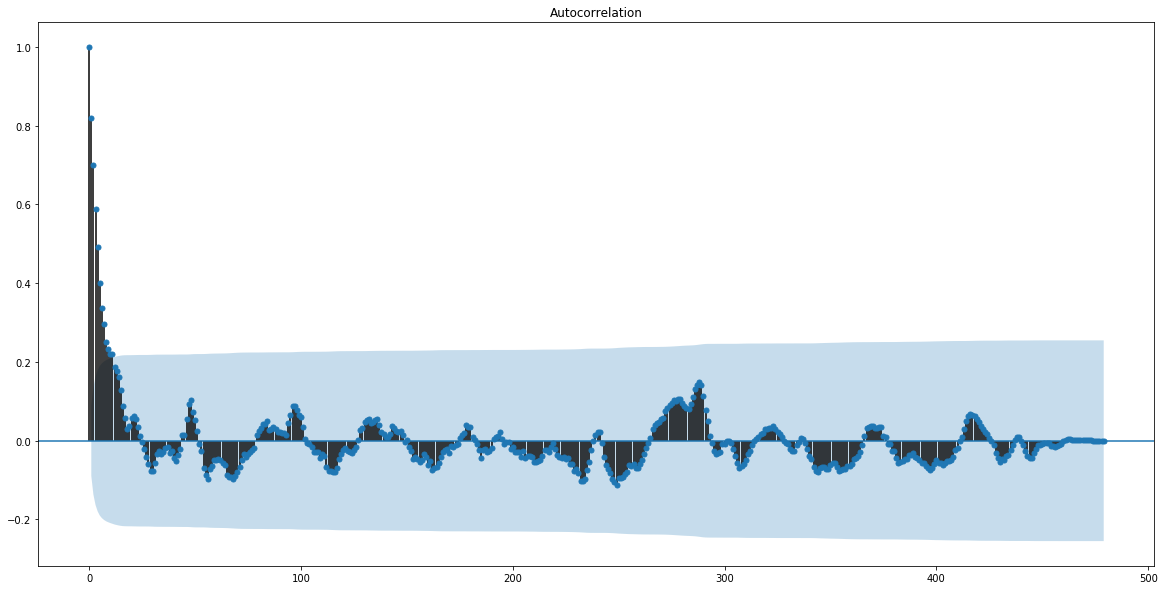

In [33]:
# Autocorrelation plot

from statsmodels.graphics.tsaplots import plot_acf
with plt.rc_context():
    plt.rc("figure", figsize=(20,10))
    plot_acf(rf_10d_residuals)

There seems to be a cyclical pattern of peaks and valleys. Since the results of the first 10 days are being analyzed, it is worth considering that there's information that could be missing (possible seasonal patterns, etc.).

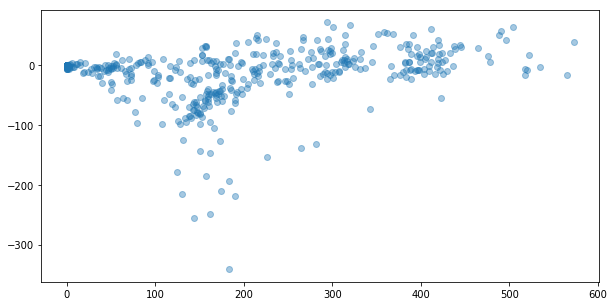

In [37]:
# Plotting residuals against fitted values:

plt.figure(figsize=(10,5))
plt.scatter(rf_10d_results['Observed_values'], rf_10d_residuals, alpha=0.4)
plt.show()

There seems to be a positive trend (the bigger the observations, the more the residuals tend to appear on the positive area).

In [38]:
rf_10d_results.head()

,Observed_values,TotEntr_PUF_allcols_10d,TotEntr_PUF_lags_10d
Timestamp,,,
2018-09-24 00:00:00,20,15.470000,15.475000
2018-09-24 00:30:00,0,5.364594,0.703488
2018-09-24 01:00:00,0,0.396983,0.000000
2018-09-24 01:30:00,0,0.000000,0.000000
2018-09-24 02:00:00,0,0.000000,0.000000


In [41]:
# Let's estimate the scoring when predicting time windows of different length into the future:

rf_future_scoring = pd.DataFrame

for i in [1, 3, 7, 10]:
    if rf_future_scoring.empty:
        rf_future_scoring = pd.DataFrame(pd.Series(np.sqrt(mean_squared_error(rf_10d_results['Observed_values'][:48], rf_10d_results['TotEntr_PUF_allcols_10d'][:48])), name = (str(i) + '-day')))

    else:
        rf_future_scoring = pd.concat([rf_future_scoring, pd.DataFrame(pd.Series(np.sqrt(mean_squared_error(rf_10d_results['Observed_values'][:48*i], rf_10d_results['TotEntr_PUF_allcols_10d'][:48*i])), name = (str(i) + '-day')))], axis=1)


rf_future_scoring = pd.DataFrame(rf_future_scoring.values.reshape(-1, 1), 
                                    index=list(rf_future_scoring.columns), 
                                    columns=['rf_RMSE'])

rf_future_R2_df = pd.DataFrame

for i in [1, 3, 7, 10]:
    if rf_future_R2_df.empty:
        rf_future_R2_df = pd.DataFrame(pd.Series(r2_score(rf_10d_results['Observed_values'][:48], rf_10d_results['TotEntr_PUF_allcols_10d'][:48]), name = (str(i) + '-day')))
        
    else:
        rf_future_R2_df = pd.concat([rf_future_R2_df, pd.DataFrame(pd.Series(r2_score(rf_10d_results['Observed_values'][:48*i], rf_10d_results['TotEntr_PUF_allcols_10d'][:48*i]), name = (str(i) + '-day')))], axis=1)
        
rf_future_R2_df = pd.DataFrame(rf_future_R2_df.values.reshape(-1, 1), index=list(rf_future_R2_df.columns), columns=['R2'])

rf_future_R2_df['rf_R2_adj'] = (1 - (1 - rf_future_R2_df['R2'])) * ((rf_10d_results.shape[0] - 1)/(rf_10d_results.shape[0] - 340 - 1))
rf_future_scoring = pd.concat([rf_future_scoring, rf_future_R2_df['rf_R2_adj']], axis=1)
rf_future_scoring

,rf_RMSE,rf_R2_adj
1-day,119.791955,-4.386607
3-day,73.051211,2.549771
7-day,53.076854,2.950123
10-day,47.711566,3.071806


10 days seem to be the time window with the best scorings, probably because extreme residuals get compensated (as the scorings are estimated for the whole period). Let's plot the distribution of absolute errors:

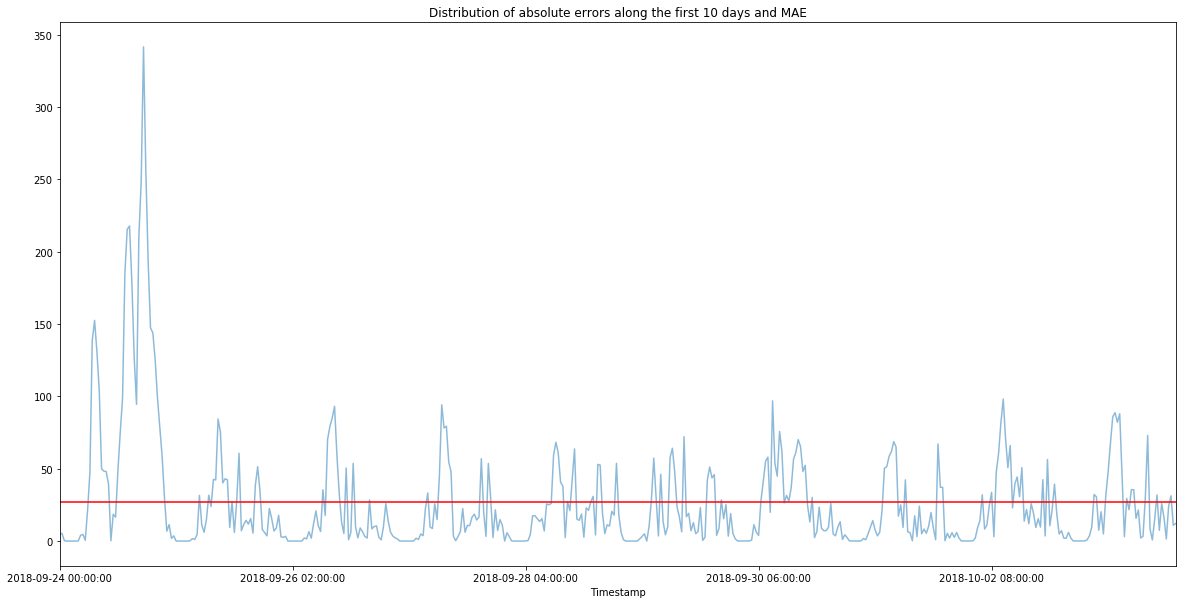

In [42]:
ax = abs(rf_10d_results['Observed_values'] - rf_10d_results['TotEntr_PUF_allcols_10d'])[:48*12].plot(figsize=(20,10), alpha=0.5, title='Distribution of absolute errors along the first 10 days and MAE')
plt.plot([mean_absolute_error(rf_10d_results['Observed_values'][:48*10], rf_10d_results['TotEntr_PUF_allcols_10d'][:48*10]) for e in range(48*10)], color='red')
plt.show()

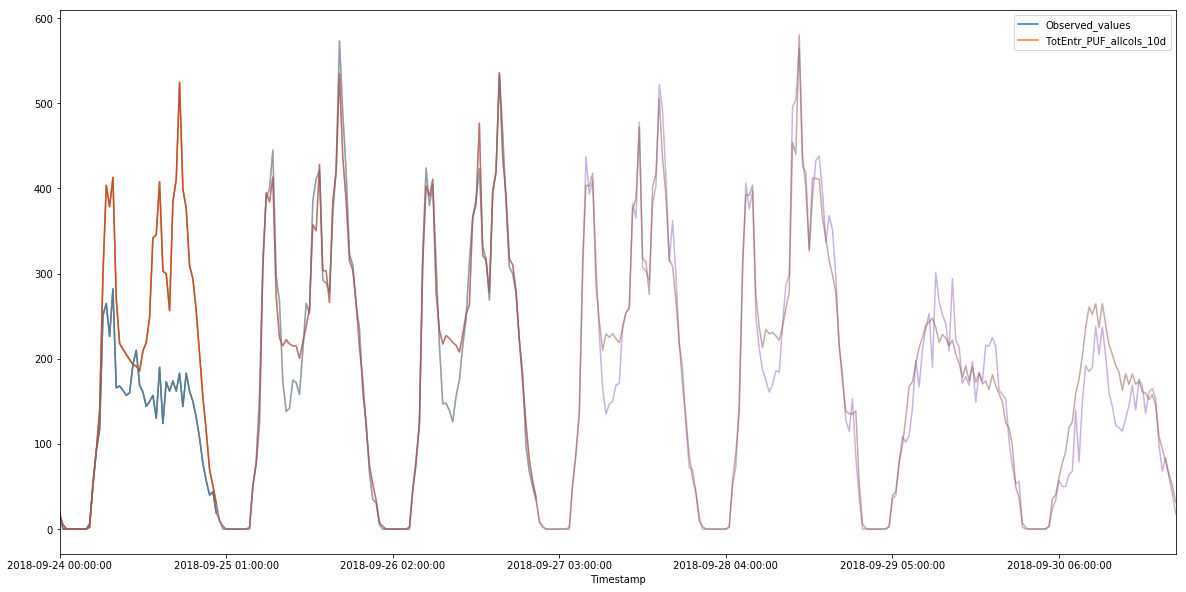

In [43]:

# Plotting observed vs. predicted along the first week

ax = rf_10d_results[['Observed_values', 'TotEntr_PUF_allcols_10d']][:48].plot(figsize=(20,10), legend=True)
rf_10d_results[['Observed_values', 'TotEntr_PUF_allcols_10d']][:48*3].plot(figsize=(20,10), alpha=0.5, legend=False, ax = ax)
rf_10d_results[['Observed_values', 'TotEntr_PUF_allcols_10d']][:48*7].plot(figsize=(20,10), alpha=0.5, legend=False, ax = ax)

plt.show()

In the first half of each day, there's a local minimum in the observations that the predictor consistently fails to capture.

### Daily frequency analysis

In [44]:
rf_DF_results.head()

,daily_observed_values,day_PKF_allcols,day_PKF_lags,day_PUF_allcols,day_PUF_lags
Timestamp,,,,,
2018-09-24,5719,9665.562973,9553.809870,9665.562973,9553.809870
2018-09-25,9998,9396.381812,9229.229885,9727.018141,9512.557773
2018-09-26,9816,9674.329971,9789.210041,9887.010106,9783.892463
2018-09-27,10087,9779.599758,9838.006070,9983.932062,9888.053528
2018-09-28,10742,10509.663615,10486.754899,10670.555464,10623.208573


In [45]:
# Allcols regressors: 10    Justlags regressors: 7

get_scoring_measures(rf_DF_results, 7, 10)

,RMSE,R2_adjusted
day_PKF_allcols,1195.749117,0.768820
day_PKF_lags,1424.127329,0.629609
day_PUF_allcols,2747.748812,-0.520075
day_PUF_lags,1525.617692,0.567859


As seen on the original frequency section, the RMSE when predicting unknown future for the whole X_test is better using just lags than using all columns.

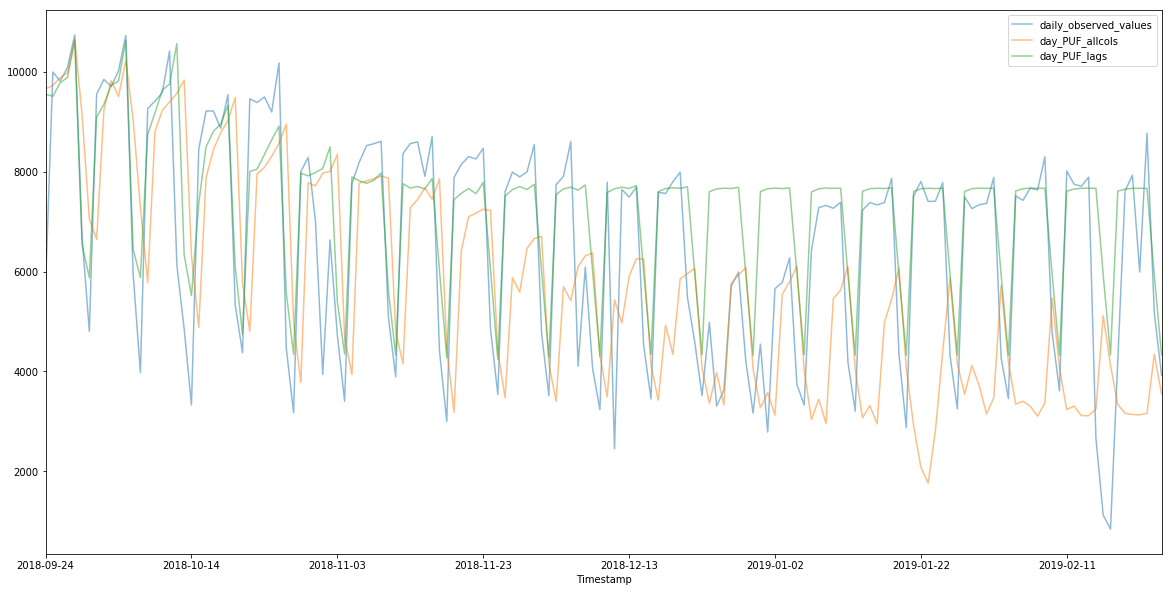

In [48]:
# Let's plot the observed values vs. the predicting unknown future scenarios:

ax = rf_DF_results.drop(['day_PKF_allcols','day_PKF_lags'], axis=1).plot(figsize=(20,10), alpha=0.5, legend=True)
plt.show()

After the first two months of predictions, the model that just use lags as regressors seems to lose its ability to capture the ups and downs shown by the observations, falling in a repetitive pattern over time.

### Comparison of results by resolution

In [51]:
rf_DF_results.head()

,daily_observed_values,day_PKF_allcols,day_PKF_lags,day_PUF_allcols,day_PUF_lags
Timestamp,,,,,
2018-09-24,5719,9665.562973,9553.809870,9665.562973,9553.809870
2018-09-25,9998,9396.381812,9229.229885,9727.018141,9512.557773
2018-09-26,9816,9674.329971,9789.210041,9887.010106,9783.892463
2018-09-27,10087,9779.599758,9838.006070,9983.932062,9888.053528
2018-09-28,10742,10509.663615,10486.754899,10670.555464,10623.208573


In [7]:
# Grouping predictions by day: comparing observed vs. 48 obs/day vs. daily predictions. Selecting the
# predictions of the model that just uses lags

obs_preds_grouped = rf_OF_results['Observed_values']
obs_preds_grouped.index = pd.to_datetime(obs_preds_grouped.index)
obs_preds_grouped = obs_preds_grouped.groupby(pd.Grouper(freq='D')).sum()

est_preds_grouped = rf_OF_results['TotEntr_PUF_lags']
est_preds_grouped.index = pd.to_datetime(est_preds_grouped.index)
est_preds_grouped = est_preds_grouped.groupby(pd.Grouper(freq='D')).sum()

grouped_predictions = pd.concat([pd.DataFrame(pd.Series(obs_preds_grouped, name='obs_vals')), pd.DataFrame(pd.Series(est_preds_grouped, name='est_preds_48/day'))], axis=1)
grouped_predictions = pd.concat([grouped_predictions, rf_DF_results['day_PUF_lags']], axis=1)
grouped_predictions.head(10)

,obs_vals,est_preds_48/day,day_PUF_lags
Timestamp,,,
2018-09-24,5719,9691.668881,9553.809870
2018-09-25,9998,10023.340293,9512.557773
2018-09-26,9816,10305.563839,9783.892463
2018-09-27,10087,10347.355741,9888.053528
2018-09-28,10742,10848.717476,10623.208573
2018-09-29,6706,6543.221873,6539.348031
2018-09-30,4801,6044.932266,5881.189485
2018-10-01,9555,9805.322503,9097.132221
2018-10-02,9850,10044.639679,9351.361293


In [8]:
get_scoring_measures(grouped_predictions, 336, 7, comparing_resolution=True)

,RMSE,R2_adjusted
est_preds_48/day,2782.783026,0.438283
day_PUF_lags,1525.617692,0.567859


In [22]:
# Estimating the total RMSE and R2_adjusted for windows of diferent span:

for x in [1, 3, 7, 10]:
    print(get_scoring_measures(grouped_predictions[:x], 336, 7, comparing_resolution=True), '     {} days'.format(str(x)))
    print('-'*50)

                         RMSE  R2_adjusted
est_preds_48/day  3972.668881         -0.0
day_PUF_lags      3834.809870         -0.0      1 days
--------------------------------------------------
                         RMSE  R2_adjusted
est_preds_48/day  2311.018024     0.002206
day_PUF_lags      2231.774465     0.110440      3 days
--------------------------------------------------
                         RMSE  R2_adjusted
est_preds_48/day  1589.045125    -0.009199
day_PUF_lags      1520.842111    -3.284648      7 days
--------------------------------------------------
                         RMSE  R2_adjusted
est_preds_48/day  1344.371338    -0.015137
day_PUF_lags      1290.337183     2.634370      10 days
--------------------------------------------------


Both for the whole test period and for the first days of observations (doesn't matter the span of the time window), the daily frequency results in a better RMSE than the high frequency.

In [55]:
# Estimating the total RMSE and R2_adj for specific days in the future:

for x in [1, 3, 7, 10]:
    print(get_scoring_measures(grouped_predictions[x-1:x], 336, 7, comparing_resolution=True), str(x)+'-days')
    print('-'*50)

                         RMSE  R2_adjusted
est_preds_48/day  3972.668881         -0.0
day_PUF_lags      3834.809870         -0.0 1-days
--------------------------------------------------
                        RMSE  R2_adjusted
est_preds_48/day  489.563839         -0.0
day_PUF_lags       32.107537         -0.0 3-days
--------------------------------------------------
                         RMSE  R2_adjusted
est_preds_48/day  1243.932266         -0.0
day_PUF_lags      1080.189485         -0.0 7-days
--------------------------------------------------
                        RMSE  R2_adjusted
est_preds_48/day  545.294531         -0.0
day_PUF_lags       26.303949         -0.0 10-days
--------------------------------------------------


The same behaviour is observed on the RMSE calculated for specfic days: the daily data yields better results than estimating 48 observations separately and adding them up afterwards.

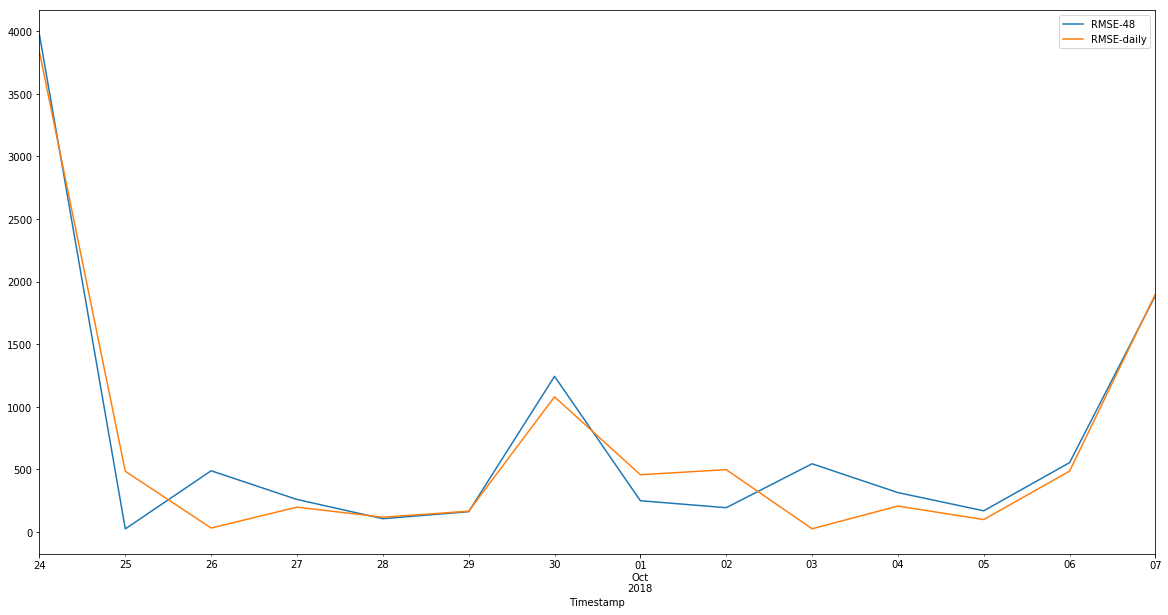

In [27]:
# Let's plot the RMSE of the 2 models (daily and 48 predictions) of the first 14 days:

RMSE_comparison_df = pd.DataFrame
RMSE_48_df = pd.DataFrame 
RMSE_daily = pd.DataFrame



for i in range(1,15):
    if RMSE_48_df.empty:
        RMSE_48_df = pd.DataFrame(pd.Series(np.sqrt(mean_squared_error(grouped_predictions['obs_vals'][:1], grouped_predictions['est_preds_48/day'][:1])), name = 'RMSE-48')) 
        RMSE_daily = pd.DataFrame(pd.Series(np.sqrt(mean_squared_error(grouped_predictions['obs_vals'][:1], grouped_predictions['day_PUF_lags'][:1])), name = 'RMSE-daily'))
        
    else:
        RMSE_48_df = pd.concat([RMSE_48_df, pd.DataFrame(pd.Series(np.sqrt(mean_squared_error(grouped_predictions['obs_vals'][i-1:i], grouped_predictions['est_preds_48/day'][i-1:i])), name = 'RMSE-48'))])
        RMSE_daily = pd.concat([RMSE_daily, pd.DataFrame(pd.Series(np.sqrt(mean_squared_error(grouped_predictions['obs_vals'][i-1:i], grouped_predictions['day_PUF_lags'][i-1:i])), name = 'RMSE-daily'))])
       
        
RMSE_comparison_df = pd.concat([RMSE_48_df, RMSE_daily], axis = 1)
RMSE_comparison_df.index = obs_preds_grouped[:len(RMSE_daily)].index

ax = RMSE_comparison_df.plot(figsize=(20,10), legend=True)
plt.show()

When plotting the RMSE for the first 14 days, in general terms the daily frequency shows better scorings but the difference doesn't seem to be vey big.

### Computing cost

In [30]:
rf_OF_runtime.columns, rf_DF_runtime.columns

(Index(['PKF_allcols_rf_runtime', 'PKF_lags_rf_runtime',
        'PUF_allcols_rf_runtime', 'PUF_lags_rf_runtime'],
       dtype='object'),
 Index(['day_PKF_allcols_rf_runtime', 'day_PKF_lags_rf_runtime',
        'day_PUF_allcols_rf_runtime', 'day_PUF_lags_rf_runtime'],
       dtype='object'))

In [36]:
# Let's create a unique data frame containing all computing costs except the 10 days refitted

rf_DF_runtime.columns = rf_OF_runtime.columns

rf_OF_runtime = pd.DataFrame(rf_OF_runtime.values.reshape(-1, 1),
                              index=list(rf_OF_runtime.columns),
                              columns=['Original_freq'])

rf_DF_runtime = pd.DataFrame(rf_DF_runtime.values.reshape(-1, 1),
                              index=list(rf_DF_runtime.columns),
                              columns=['Daily_freq'])

runtime_df = pd.concat([rf_OF_runtime, rf_DF_runtime], axis = 1)
runtime_df / 3600

,Original_freq,Daily_freq
PKF_allcols_rf_runtime,0.103288,0.000115
PKF_lags_rf_runtime,0.107361,0.000112
PUF_allcols_rf_runtime,1.549273,0.018828
PUF_lags_rf_runtime,1.324650,0.018814


When predicting unknown future at high frequency without refitting, there's not much difference in runtime using all columns vs. using just lags. There is a big difference, though, when compared vs. the runtime of the daily data.

In [37]:
# Let's see the time taken to predict 10 days of high frequency data refitting the model in each iteration:

rf_10d_runtime / 3600

,PUF_allcols_lr_runtime_10d,PUF_lags_rf_runtime_10d
0,50.388467,50.599561


The time to compute 10 days of predictions at a frequency of 48 observations per day takes 50 hours to compute. As seen in the first section of the notebook, whilst refitting the model each iteration dramatically improves the scorings when using all columns, it almost doesn't make a difference using just lags.

Anyhow, in the trade-off between accuracy and runtime, the winner is the model that consumes daily data using just lags.